1. Plotting actual vs predicted using all data (fit NN to all data first)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the TensorBoard notebook extension.

%reload_ext tensorboard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import pickle
from pickle import load , dump
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns
import tensorboard
tensorboard.__version__

'2.6.0'

In [4]:
MicroclimateData = pd.read_csv('/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Combined/all_buildings_limited.csv')
WeatherStationData = pd.read_csv('/content/drive/Shareddrives/Microclimate-Building Energy/Data/NN_big_data/Combined/all_buildings_big.csv')

In [5]:
# Function to split same percent for each unique data in df column
def split_unique(dataset, column, test_size):
  X_train2 = pd.DataFrame()
  X_test2 = pd.DataFrame()
  y_train2 = pd.DataFrame()
  y_test2 = pd.DataFrame()
  for i,C in enumerate(dataset[column].unique()):
    X = dataset[dataset[column] == C][['bldgname',
                                    'Air Temp', 
                                    'Abs Hum',
                                    'DSW Top', 
                                    'DSW North', 
                                    'DSW South', 
                                    'DSW East', 
                                    'DSW West', 
                                    'Shade North', 
                                    'Shade East', 
                                    'Shade West',
                                    'Shade South']]
    y = dataset[dataset[column] == C]['CHWTON/SQFT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
    X_train2 = X_train2.append(X_train)
    X_test2 = X_test2.append(X_test)
    y_train2 = y_train2.append(y_train)
    y_test2 = y_test2.append(y_test)
  return X_train2, X_test2, y_train2, y_test2

# Split microclimate data 20% from each building for testing
X_train2, X_test2, y_train2, y_test2 = split_unique(MicroclimateData, 'bldgname', 0.2)
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)

# Check number of points in each building
# Note: Biodesign C has less data than all other buildings in original data
# for i,C in enumerate(MicroclimateData['bldgname'].unique()):
#   print(C, ":", len(MicroclimateData[MicroclimateData['bldgname']==C]))

(7668, 12)
(11, 7668)
(1921, 12)


## Flow of Code:
#### 1. Read both datasets, and do data preparation: Scaling, One-hot Encoding
#### 2. For limited data, train  model on Temp, Hum, Dsw(4), Shade(4), Encoding input features (find hyperparameters analytically)
#### 3. For big data, train model on Temp, Hum, Encoding 
#### 4. Fine tune weather station model on microclimate data and compare performance
#### 5. Work on adding artificial features and dropout on microclimate model

In [6]:
class NeuralNetwork():
    def __init__(self,activation_type, hidden_layers, loss, kernel_initializer, bias_initializer, data_type,epochs):
        self.activation_type = activation_type
        self.hidden_layers = hidden_layers
        self.loss = loss
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer 
        self.data_type = data_type
        self.epochs = epochs
        self.scaler = StandardScaler()

    def huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = tf.keras.backend.abs(error) < clip_delta
        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
        return tf.where(cond, squared_loss, linear_loss)
        
    def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
        return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))
    # Function to split same percent for each unique data in df column
    def split_unique(dataset, column, data_columns, test_size):
        X_train2 = pd.DataFrame()
        X_test2 = pd.DataFrame()
        y_train2 = pd.DataFrame()
        y_test2 = pd.DataFrame()
        for i,C in enumerate(dataset[column].unique()):
            X = dataset[dataset[column] == C][data_columns]
            y = dataset[dataset[column] == C]['CHWTON/SQFT']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
            X_train2 = X_train2.append(X_train)
            X_test2 = X_test2.append(X_test)
            y_train2 = y_train2.append(y_train)
            y_test2 = y_test2.append(y_test)
        return X_train2, X_test2, y_train2, y_test2
        
    def prepare_data(self, dataset, func):        
        #add artificial features
        dataset['Air Temp Squared'] =  dataset['Air Temp']**2
        dataset['Abs Hum Squared'] =  dataset['Abs Hum']**2
        dataset['Air Temp*Abs Hum'] =  dataset['Air Temp']* dataset['Abs Hum']
        MicroclimateData['Air Temp Squared'] =  MicroclimateData['Air Temp']**2
        MicroclimateData['Abs Hum Squared'] =  MicroclimateData['Abs Hum']**2
        MicroclimateData['Air Temp*Abs Hum'] =  MicroclimateData['Air Temp']* MicroclimateData['Abs Hum']
        if self.data_type == 'WeatherStation'  and (func == 'test' or func == 'train'):
            X = dataset[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = dataset['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'train':
            X = MicroclimateData[['bldgname',
                                  'Air Temp', 
                                  'Abs Hum',
                                  'Air Temp Squared',
                                  'Abs Hum Squared',
                                  'Air Temp*Abs Hum',
                                  'DSW Top', 
                                  'DSW North', 
                                  'DSW South', 
                                  'DSW East', 
                                  'DSW West', 
                                  'Shade North', 
                                  'Shade East', 
                                  'Shade West',
                                  'Shade South']]
            columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
                        'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
                       'DSW North', 'DSW South', 'DSW East','DSW West',
                       'Shade North', 'Shade East', 'Shade West', 'Shade South',]
            Y = MicroclimateData['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'test':
            X = MicroclimateData[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = MicroclimateData['CHWTON/SQFT']
        Y = Y.values.reshape(-1, 1)
        Y = self.scaler.fit_transform(Y)
        X = pd.get_dummies(X)
        StdSc2 = StandardScaler()
        X[columns] = StdSc2.fit_transform(X[columns])
#         X_train, X_test, y_train, y_test = self.split_unique(X, 'bldgname', columns, 0.2)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=0.2, 
                                                            random_state=20)
        return X_train, X_test, y_train, y_test
    def define_model(self):
        if self.data_type == 'WeatherStation' :
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(20, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(30, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.2))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.2))
                model.add(Dense(1, activation = 'linear'))           
        if self.data_type == 'Microclimate':
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.2))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.2))
                model.add(Dense(1, activation = 'linear'))
        model.compile( loss = self.loss, 
                      optimizer = 'adam')
        model.summary()
        return model
    def train(self, dataset):
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'train')
        self.model = self.define_model()
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            callbacks=[tensorboard_callback])
    def fine_tune(self, dataset,alpha=0.001):
        self.model.trainable = True
        fine_tune_at = 2
        for layer in self.model.layers[:fine_tune_at]:
            layer.trainable =  False
        opt = Adam(learning_rate = alpha)    
        self.model.compile(loss=self.loss, 
                           optimizer=opt)
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'test')
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            callbacks=[tensorboard_callback])
        
        
    def plot_curve(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    def evaluate(self, dataset, data_type ):
        call_type = 'test'
        if data_type == self.data_type:
            call_type = 'train'
        _, X_test, _, y_test = self.prepare_data(dataset,call_type)
        Y_preds = self.model.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
        R2_score = metrics.r2_score(y_test, Y_preds)
        print("The RMSE score for test dataset of "+ data_type +" on model type:" + self.data_type + " model " +" is:", RMSE) 
        print("The R2 score for test dataset of "+ data_type +" on model type:" + self.data_type + " model " +" is:", R2_score)
        return Y_preds, y_test, X_test 

In [7]:
if __name__ == "__main__":
    # Train microclimate Model
    MicroclimateModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'Microclimate', 250)
    MicroclimateModel.train(MicroclimateData)
    Y_preds_NN, y_test_NN, X_test_NN = MicroclimateModel.evaluate(MicroclimateData, 'Microclimate')
    # Train Weather Station Model
    WeatherStationModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'WeatherStation', 100)
    WeatherStationModel.train(WeatherStationData)
    _,_,_ = WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')
   


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                780       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2050      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
______________________________________________________

In [8]:
 def ParameterTuning():
  l_rates = [0.001,0.00125,0.0015,0.00175,0.002,0.003,0.01]
  R2_max=0
  RMSE_min=1
  lr=0
  for a in l_rates:
    WeatherStationModel.fine_tune(MicroclimateData,alpha=a)
    Y_preds, y_test, X_test = WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')
    RMSE_fine_tune = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
    R2_fine_tune = metrics.r2_score(y_test, Y_preds)
    if R2_fine_tune>R2_max and RMSE_fine_tune<RMSE_min:
      lr=a
      R2_max=R2_fine_tune
      RMSE_min=RMSE_fine_tune
  print(lr)  
  return lr


In [9]:
 # Fine Tune and compare results
WeatherStationModel.fine_tune(MicroclimateData)
Y_preds_TL, y_test_TL, X_test_TL = WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')
learning_rate = ParameterTuning()
_,_,_ = WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')

The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.1571337965911741
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.974518352503493
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.1531805540515035
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9757843813934249
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.15219484016040413
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9760950327205808
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.15299910318131776
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9758417169039211
The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.14690402285079582
The R2 score for test dataset of Microclima

Use this to return dummy variables to original columns example: df2 = undummify(df2) 

## Plotting

In [10]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

0 Psychology
1 Goldwater
2 Schwada COB
3 Bulldog Hall
4 ISTB 4
5 Psychology North
6 Biodesign C
7 Biodesign A
8 Biodesign B
9 Noble Library
10 ISTB 2
[5 6 7 8 9]
Enter the month from the list above: 8
[ 1  3  7  8 11 16 20 21 23 25 26 27 29]
Enter the day from the list above: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

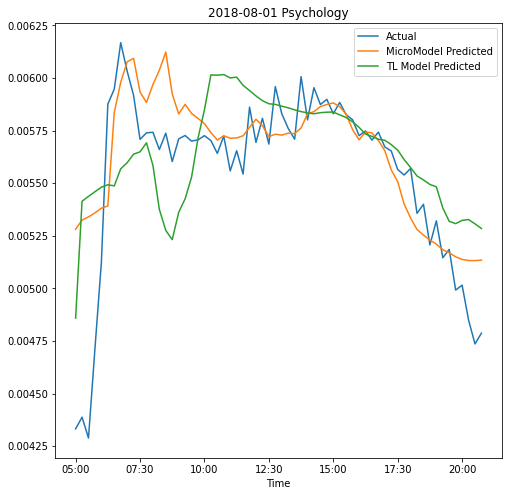

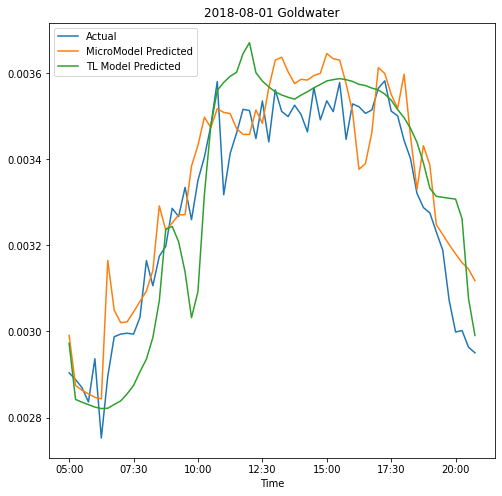

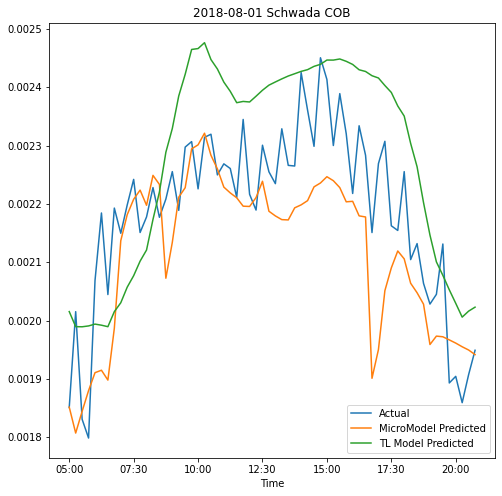

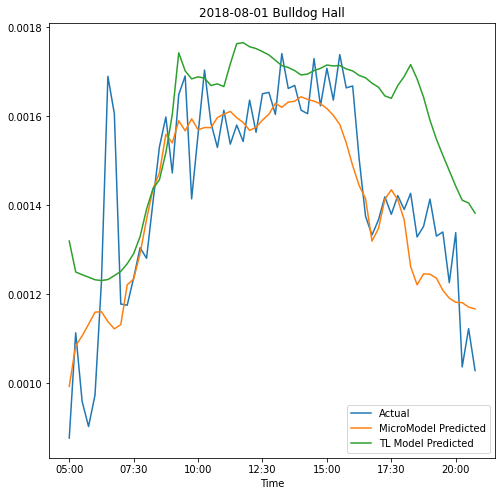

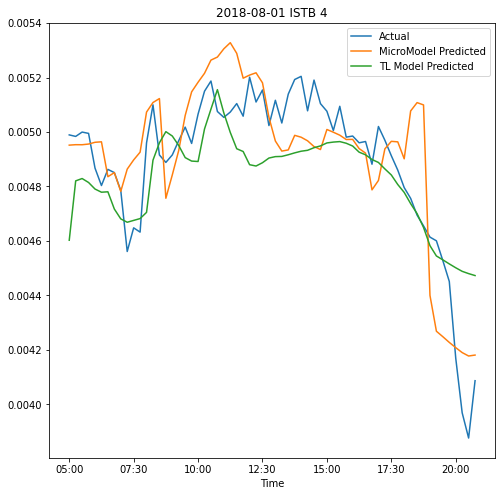

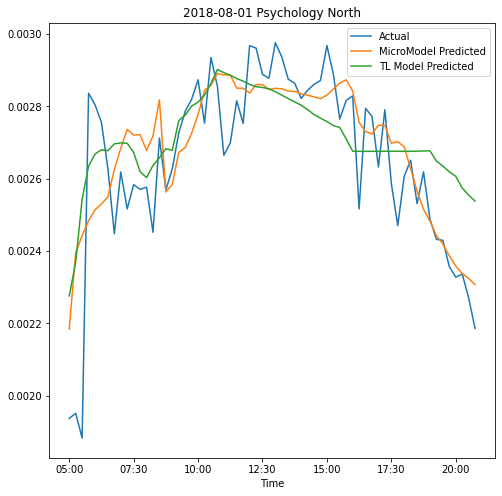

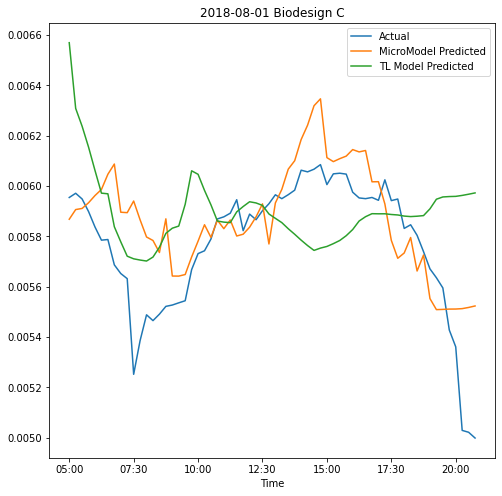

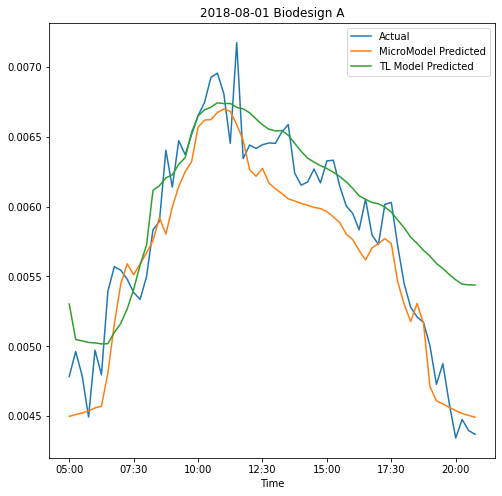

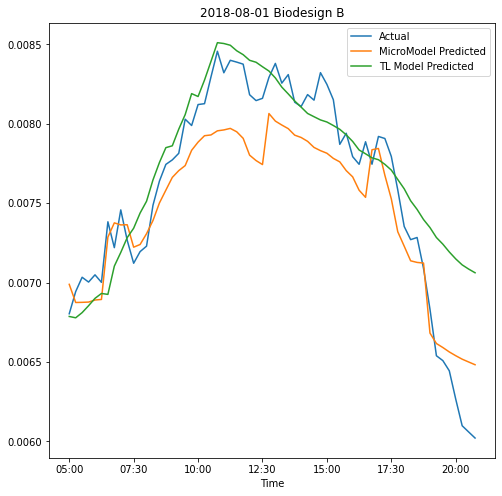

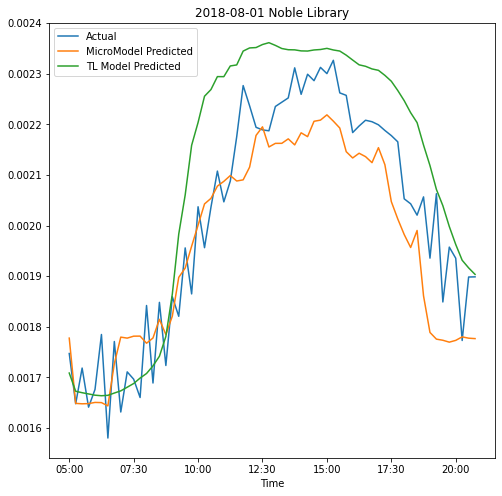

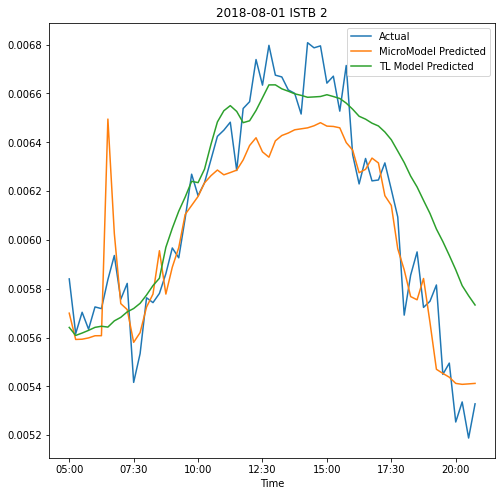

In [21]:
date_time = MicroclimateData[['Date_Time',
                        'Month',
                        'Day',
                        'Hour',
                        'Minute']]

x1,x2,y1,y2 = MicroclimateModel.prepare_data(MicroclimateData,'train')

# Microclimate Model(NN)
StdSc1 = StandardScaler()
comb1 = [x1,x2]
x1 = pd.concat(comb1)
Y_preds_NN = MicroclimateModel.model.predict(x1)
results_NN = undummify(x1).join(date_time)
col = results_NN.pop('bldgname')
results_NN.insert(0, 'bldgname', col)
y1= np.concatenate((y1,y2))
results_NN['Actual'] = MicroclimateModel.scaler.inverse_transform(y1)
results_NN['Time'] = results_NN['Date_Time'].str[11:16]
results_NN['Predicted'] = MicroclimateModel.scaler.inverse_transform(Y_preds_NN)

x3,x4,y3,y4 = WeatherStationModel.prepare_data(MicroclimateData,'test')

#Transfer Learning Model(TL)
StdSc2 = StandardScaler()
comb2 = [x3,x4]
x3 = pd.concat(comb2)
Y_preds_TL = WeatherStationModel.model.predict(x3)
results_TL = undummify(x3).join(date_time)
col = results_TL.pop('bldgname')
results_TL.insert(0, 'bldgname', col)
y3= np.concatenate((y3,y4))
results_TL['Actual'] = WeatherStationModel.scaler.inverse_transform(y3)
results_TL['Time'] = results_NN['Date_Time'].str[11:16]
results_TL['Predicted'] = WeatherStationModel.scaler.inverse_transform(Y_preds_TL)


# User input Building name
Buildings = results_NN['bldgname'].unique()
for i in range(len(Buildings)):
    print(i, Buildings[i])

# User input Month
print(np.sort(results_NN['Month'].unique()))

mnth_num = int(input("Enter the month from the list above: "))

month_NN = results_NN[results_NN['Month'] == mnth_num]
month_TL = results_TL[results_TL['Month'] == mnth_num]

# User input Day
print(np.sort(results_NN['Day'].unique()))
day_num = int(input("Enter the day from the list above: "))
day_NN = month_NN[month_NN['Day'] == day_num]
day_TL = month_TL[month_TL['Day'] == day_num]

for bldg in Buildings:
  bldg_NN = day_NN[results_NN['bldgname']==bldg]
  bldg_TL = day_TL[results_TL['bldgname']==bldg]

  values_NN = bldg_NN.sort_values(by=['Time'])
  values_TL = bldg_TL.sort_values(by=['Time'])
  values_NN['MicroModel Predicted'] = values_NN['Predicted']
  values_TL['TL Model Predicted'] = values_TL['Predicted']


  ax = values_NN.plot(x='Time',y='Actual',grid = False, figsize = (8,8))
  values_NN.plot(x='Time',y='MicroModel Predicted',grid = False, figsize = (8,8),ax=ax)
  values_TL.plot(x='Time',y='TL Model Predicted',grid = False, figsize = (8,8),ax=ax)
  ind = values_NN.index
  ax.title.set_text(values_NN['Date_Time'][ind[0]][0:10] +' '+ bldg)

In [20]:
print(values_NN['Date_Time'])
print((values_NN['Date_Time'][ind[0]][0:10] +' '+ bldg))

3900    2018-08-01 05:00:00
3901    2018-08-01 05:15:00
3902    2018-08-01 05:30:00
3903    2018-08-01 05:45:00
3904    2018-08-01 06:00:00
               ...         
3959    2018-08-01 19:45:00
3960    2018-08-01 20:00:00
3961    2018-08-01 20:15:00
3962    2018-08-01 20:30:00
3963    2018-08-01 20:45:00
Name: Date_Time, Length: 64, dtype: object
2018-08-01 Psychology


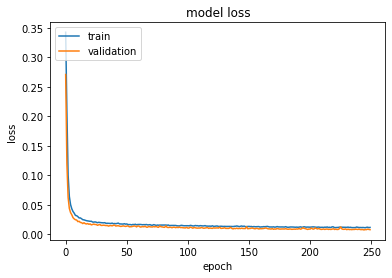

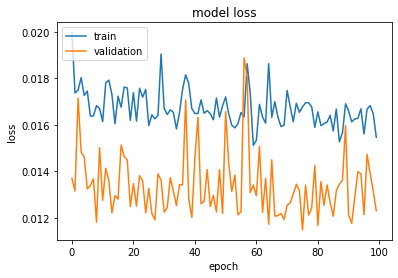

In [22]:
MicroclimateModel.plot_curve()
WeatherStationModel.plot_curve()